In [184]:
import duckdb
conn = duckdb.connect('cnpj.db')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [185]:
tables = conn.execute("SHOW TABLES").fetchall()
tables = [t[0] for t in tables]
tables = [t for t in tables if not t.endswith("_raw")]
print(tables)

['cnae', 'empresas', 'estabelecimentos', 'natureza', 'simple', 'socios']


In [186]:
for table in tables:
    count = conn.execute(f"SELECT COUNT(*) FROM {table}").df().iloc[0,0]
    print(f"{table}: {count}")

cnae: 1358
empresas: 56554307
estabelecimentos: 59495407
natureza: 89
simple: 38371644
socios: 23765603


# Question 1
## How many companies there registed in brazil until last year?

In [187]:
companies_bys_year = conn.execute("""SELECT left(activity_start_date, 4) AS year
                                  , COUNT(*) AS new_companies
                                  , SUM(COUNT(*)) OVER (ORDER BY year) AS total_companies
                                    FROM ESTABELECIMENTOS
                                    WHERE identifier IN (1)
                                    GROUP BY year
                                    ORDER BY year DESC;""").df()
#remove last year because it is not complete
companies_bys_year = companies_bys_year.iloc[1:]
companies_bys_year.head(5)

,year,new_companies,total_companies
1,2023,3852651,56062893.0
2,2022,3855778,52210242.0
3,2021,4019863,48354464.0
4,2020,3915072,44334601.0
5,2019,3167006,40419529.0


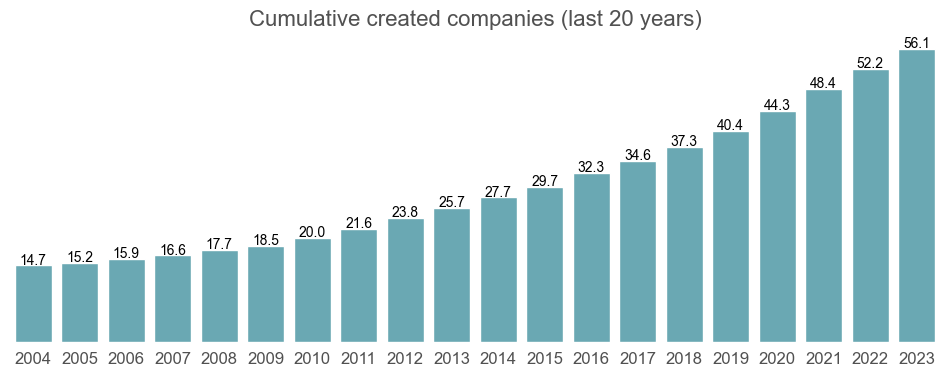

In [188]:
# plotting the time series of cumulative companies created per year
plot_df = companies_bys_year.copy().head(20).sort_values('year', ascending=True).reset_index()

plot_df["total_companies"] = (plot_df["total_companies"] / 1000000).round(1)
# converting year to datetime
plot_df['year'] = pd.to_datetime(plot_df['year']).dt.year

# Plotting the time series of companies created per year
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.barplot(data=plot_df,  y='total_companies',x='year', color='#5EB1BF')
plt.title("Cumulative created companies (last 20 years)", fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)

for index, row in plot_df.iterrows():
    plt.text(row.name, row.total_companies + 0.2, str(row.total_companies), color='black', ha="center", fontsize=10)

# Question 2
## How many each year?

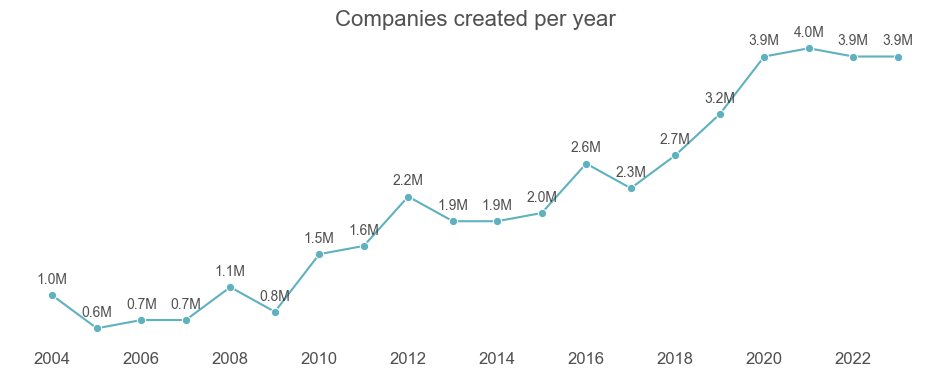

In [189]:
# Plotting time series of companies created per year

plot_df = companies_bys_year.copy().head(20)
plot_df["new_companies"] = (plot_df["new_companies"] / 1000000).round(1)
# converting year to datetime
plot_df['year'] = pd.to_datetime(plot_df['year'])
# Plotting the time series of companies created per year



plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.lineplot(data=plot_df, x='year', y='new_companies', marker='o', color='#5EB1BF')
plt.title("Companies created per year", fontsize=16, alpha=0.8)
# removing y-axis labels and text
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8);
plt.box(False)

# Adding data labels
for index, row in plot_df.iterrows():
    plt.text(row['year'], row['new_companies'] + 0.1, f'{row["new_companies"]}M', ha = 'center', va = 'bottom', fontsize=10, alpha=0.8)
plt.show()



# Question 3
## How many are still active?

In [190]:
companies_bys_status = conn.execute("""SELECT 
                                        CASE 
                                            WHEN registration_status = 1 THEN 'NULL'
                                            WHEN registration_status = 2 THEN 'ACTIVE'
                                            WHEN registration_status = 3 THEN 'SUSPENDED'
                                            WHEN registration_status = 4 THEN 'INACTIVE'
                                            WHEN registration_status = 8 THEN 'CLOSED'
                                        END AS status_name,
                                        COUNT(*) AS companies_count,
                                        ROUND((COUNT(*) * 100.0) / SUM(COUNT(*)) OVER (), 1) AS percentage,
                                    FROM 
                                        ESTABELECIMENTOS 
                                    WHERE 
                                        identifier IN (1)
                                    GROUP BY 
                                        ALL
                                    ORDER BY 
                                        companies_count DESC;""").df()
companies_bys_status.head(5)

,status_name,companies_count,percentage
0,CLOSED,25193287,44.5
1,ACTIVE,22311186,39.5
2,INACTIVE,8714513,15.4
3,SUSPENDED,244469,0.4
4,NULL,90853,0.2


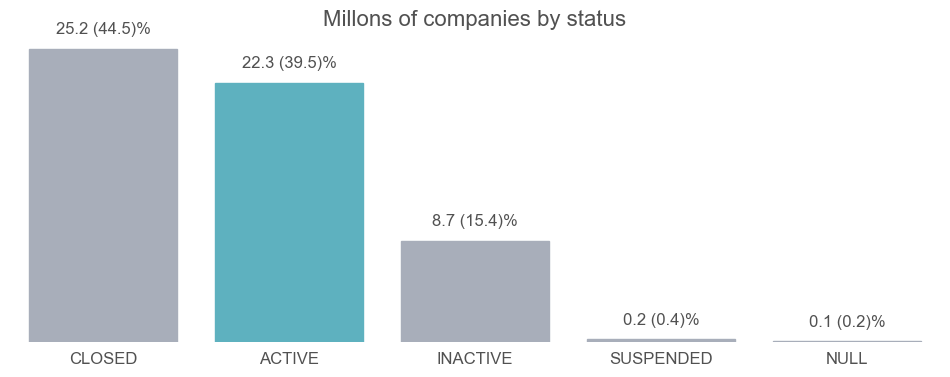

In [191]:
# Plotting the distribution of companies by status adding data labels and removing the grid lines, y-axis labels and canvas border
plt.figure(figsize=(12, 4))
sns.set_style("white")
sns.barplot(data=companies_bys_status, x='status_name', y='companies_count', legend=False)

# cooring the bar that represents the active companies and all the other bars in gray
active_index = companies_bys_status[companies_bys_status['status_name'] == 'ACTIVE'].index[0]
for i in range(companies_bys_status.shape[0]):
    if i != active_index:
        plt.gca().get_children()[i].set_color('#A8AEBA')
    else:
        plt.gca().get_children()[i].set_color('#5EB1BF')

plt.title('Millons of companies by status', fontsize=16, alpha=0.8)
# Adding the data labels
for i in range(companies_bys_status.shape[0]):
    count = companies_bys_status.iloc[i]['companies_count'] 
    percentage = companies_bys_status.iloc[i]['percentage']
    plt.text(i, count + 10**6, f'{round(count/1000000,1)} ({percentage})%', ha = 'center', va = 'bottom', fontsize=12, alpha=0.8)
#removing y-axis labels and text
plt.ylabel('')
plt.xlabel('')
plt.yticks([])
# x axis label alpah and fontsize
plt.xticks(fontsize=12, alpha=0.8)
plt.box(False)
plt.show()